# Prediction Model of WhistleOut
A supervised learning machine learning model using boosting technique attempts to identify features contributing to transactions done in WhistleOut webpage. Furthermore, the model attempts to sort out a list telling us how important of each main feature is towards transactions and how accurate the prediction can be achieved.

## 1 Data Import
1. Import the master data spreadsheet with relevant columns only.
2. Filter records under Mobile Phone only (not to get confused with Broadband business).
3. Sample the data.

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/Shareddrives/protik/iLab/Dataset/clean'

Mounted at /content/drive
/content/drive/Shareddrives/protik/iLab/Dataset/clean


In [ ]:
df = pd.read_csv("finalbq.csv")

# Display the first few rows of the DataFrame
df.head()

,session_ID,ViewedOnTime,ViewedOnDate,ProductKey,CampaignKey,UserIdKey,SupplierKey,PageCount,IsAd,IsTransaction,...,IncludedDataDescriptionGB,DataRate,IncludedValueContainsMms,IncludedValueContainsVideo,MobilePlanTypeName,MobilePlanTypeNameDerived,is5GNetwork,MobilePhonePlan,MobilePhoneNetworkName,MobilePhoneNetworkID
0,277986771,15:50:08,2023-01-08,10774,21011,44206972,2087,0,0,1,...,22GB,0.0,1,0,Postpaid,Postpaid,0,1,Telstra,2
1,277864634,09:43:03,2023-01-06,10774,21011,45129543,2087,0,0,1,...,22GB,0.0,1,0,Postpaid,Postpaid,0,1,Telstra,2
2,278381435,11:13:31,2023-01-16,10774,21011,46031543,2087,0,0,1,...,22GB,0.0,1,0,Postpaid,Postpaid,0,1,Telstra,2
3,277356663,01:36:17,2022-12-27,10774,21011,27907780,2087,0,0,1,...,22GB,0.0,1,0,Postpaid,Postpaid,0,1,Telstra,2
4,278521249,22:29:14,2023-01-18,10774,21011,46419622,2087,0,0,1,...,22GB,0.0,1,0,Postpaid,Postpaid,0,1,Telstra,2


In [ ]:
# # SearchCrieriaKey has no effect on IsTranaction
# df[df['IsTransaction'] == 1]['SearchCriteriaKey'].unique()
# # URLKey is also useless as it always shows the URL to purchase
# # Campaign is duplicated with CampaignKey

In [ ]:
# # Drop it to avoid XGBoost using it as the sole split
# df.drop(columns=['SearchCriteriaKey', 'URLKey', 'Campaign'], inplace=True)
# df.head()

In [ ]:
df.shape

(122087, 92)

In [ ]:
## Remove theIsTransaction=0
#df = df[df['IsTransaction']==1]
df.shape

(122087, 92)

In [ ]:
## get all the names with key and id
# Define the substrings to search for in column names
substrings_to_search = ['key', 'comment', 'id', 'tablet']

# Get the column names that contain those word
matching_columns = [col for col in df.columns if any(sub in col.lower() for sub in substrings_to_search)]

# Print the matching column names
print("Columns containing 'key,' 'comment,', 'id' or 'tablet in their names:")
for col in matching_columns:
    print(col)

Columns containing 'key,' 'comment,', 'id' or 'tablet in their names:
session_ID
ProductKey
CampaignKey
UserIdKey
SupplierKey
product_indv_ID
SupplierID
MobileProductKey
campaign_indv_ID
SupplierID_campaign_table
supplier_indv_ID
ProductID
DomesticVideoFlagFall
DomesticVideoCallRate
IncludedValueContainsVideo
MobilePhoneNetworkID


In [ ]:
# Drop the specified columns
df = df.drop(columns=matching_columns)
df.shape

(122087, 76)

In [ ]:
df.dtypes

ViewedOnTime                 object
ViewedOnDate                 object
PageCount                     int64
IsAd                          int64
IsTransaction                 int64
                              ...  
MobilePlanTypeName           object
MobilePlanTypeNameDerived    object
is5GNetwork                   int64
MobilePhonePlan               int64
MobilePhoneNetworkName       object
Length: 76, dtype: object

In [ ]:
def convertToCat(df):
    # # Convert all columns to 'category' data type
    for column in df.columns:
        df[column] = df[column].astype('category')

In [ ]:
df.columns

Index(['ViewedOnTime', 'ViewedOnDate', 'PageCount', 'IsAd', 'IsTransaction',
       'IsProduct', 'AffiliateName', 'DeviceType', 'Source', 'Medium',
       'Campaign', 'WOHeadlinePlanFixedDiscount', 'WOHeadlinePhoneDiscount',
       'WOHeadlineExtraDataDiscount', 'OneOffFeeTotal', 'Phonemonthlycost',
       'StartDate', 'EndDate', 'Name', 'CurrentName', 'Active', 'Preview',
       'BaseCost', 'PaymentFrequency', 'PaymentFrequencyDerived_in_days',
       'PaymentPeriod', 'GlobalShowOnWhistleout', 'EditorsPickName',
       'StartDate_campaign_table', 'EndDate_campaign_table',
       'Active_campaign_table', 'Preview_campaign_table',
       'Name_campaign_table', 'Sequence', 'BusinessStartDate',
       'BusinessEndDate', 'PromotionName', 'Exclusive',
       'OtherIncentive1mthTCOTotal', 'OtherIncentive6mthTCOTotal',
       'OtherIncentive12mthTCOTotal', 'OtherIncentiveOneOffTotal',
       'FixedIncentive1mthTCOTotal', 'FixedIncentive6mthTCOTotal',
       'FixedIncentive12mthTCOTotal', 'Fix

In [ ]:
df.drop(columns=['PageCount', 'Sequence','Campaign'], inplace=True)

In [ ]:
df.columns

Index(['ViewedOnTime', 'ViewedOnDate', 'IsAd', 'IsTransaction', 'IsProduct',
       'AffiliateName', 'DeviceType', 'Source', 'Medium',
       'WOHeadlinePlanFixedDiscount', 'WOHeadlinePhoneDiscount',
       'WOHeadlineExtraDataDiscount', 'OneOffFeeTotal', 'Phonemonthlycost',
       'StartDate', 'EndDate', 'Name', 'CurrentName', 'Active', 'Preview',
       'BaseCost', 'PaymentFrequency', 'PaymentFrequencyDerived_in_days',
       'PaymentPeriod', 'GlobalShowOnWhistleout', 'EditorsPickName',
       'StartDate_campaign_table', 'EndDate_campaign_table',
       'Active_campaign_table', 'Preview_campaign_table',
       'Name_campaign_table', 'BusinessStartDate', 'BusinessEndDate',
       'PromotionName', 'Exclusive', 'OtherIncentive1mthTCOTotal',
       'OtherIncentive6mthTCOTotal', 'OtherIncentive12mthTCOTotal',
       'OtherIncentiveOneOffTotal', 'FixedIncentive1mthTCOTotal',
       'FixedIncentive6mthTCOTotal', 'FixedIncentive12mthTCOTotal',
       'FixedIncentiveOneOffTotal', 'PercentageI

# column to drop


In [ ]:
# for market share
drop_column = ['ViewedOnTime', 'IsProduct', 'DeviceType','WOHeadlinePhoneDiscount','StartDate', 'EndDate', 'CurrentName','Active','Preview', 'PaymentFrequency',
               'PaymentPeriod','StartDate_campaign_table', 'EndDate_campaign_table','Active_campaign_table', 'Preview_campaign_table', 'BusinessStartDate', 'BusinessEndDate',
               'PromotionName', 'Exclusive', 'StartDate_supplier_table', 'EndDate_supplier_table', 'StartDate_mobileproduct_table','EndDate_mobileproduct_table',
               'IncludedDataDescriptionMB', 'IncludedDataDescriptionGB', 'BaseCost']

# Drop the specified columns for market share
df_mkt_share = df.drop(columns=drop_column)
print(f"Data Shape for Market Share: {df_mkt_share.shape}")

# for transaction
drop_column = ['ViewedOnTime', 'ViewedOnDate', 'IsProduct', 'DeviceType','WOHeadlinePhoneDiscount','StartDate', 'EndDate', 'CurrentName','Active','Preview', 'PaymentFrequency',
               'PaymentPeriod','StartDate_campaign_table', 'EndDate_campaign_table','Active_campaign_table', 'Preview_campaign_table', 'BusinessStartDate', 'BusinessEndDate',
               'PromotionName', 'Exclusive', 'StartDate_supplier_table', 'EndDate_supplier_table', 'StartDate_mobileproduct_table','EndDate_mobileproduct_table',
               'IncludedDataDescriptionMB', 'IncludedDataDescriptionGB', 'BaseCost']
# Drop the specified columns for Transaction
df = df.drop(columns=drop_column)
print(f"Data Shape for Transaction: {df.shape}")

Data Shape for Market Share: (122087, 47)
Data Shape for Transaction: (122087, 46)


In [ ]:
df.columns

Index(['IsAd', 'IsTransaction', 'AffiliateName', 'Source', 'Medium',
       'WOHeadlinePlanFixedDiscount', 'WOHeadlineExtraDataDiscount',
       'OneOffFeeTotal', 'Phonemonthlycost', 'Name',
       'PaymentFrequencyDerived_in_days', 'GlobalShowOnWhistleout',
       'EditorsPickName', 'Name_campaign_table', 'OtherIncentive1mthTCOTotal',
       'OtherIncentive6mthTCOTotal', 'OtherIncentive12mthTCOTotal',
       'OtherIncentiveOneOffTotal', 'FixedIncentive1mthTCOTotal',
       'FixedIncentive6mthTCOTotal', 'FixedIncentive12mthTCOTotal',
       'FixedIncentiveOneOffTotal', 'PercentageIncentive1mthTCOTotal',
       'PercentageIncentive6mthTCOTotal', 'PercentageIncentive12mthTCOTotal',
       'PercentageIncentiveOneOffTotal', 'PhoneIncentive1mthTCOTotal',
       'PhoneIncentive6mthTCOTotal', 'PhoneIncentive12mthTCOTotal',
       'ExtraIncentive1mthTCOTotal', 'ExtraIncentive6mthTCOTotal',
       'ExtraIncentive12mthTCOTotal', 'ExtraIncentiveOneOffTotal',
       'Name_supplier_table', 'Domesti

In [ ]:
df = df[df['Name_supplier_table'] == 'iiNet']
df = df.drop(columns=['Name_supplier_table'])
df.shape

(15682, 45)

## 3 Analysis
1. Split the data into label and features.
2. Further split the data into training and testing.
3. Define prediction model algorithm: XGBoost.
4. Train the model.
5. Show feature importance chart.
6. Evaluate the model.

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade xgboost

In [ ]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['AffiliateName', 'Source', 'Medium', 'Name', 'Name_campaign_table', 'MobilePlanTypeName', 'MobilePlanTypeNameDerived', 'MobilePhoneNetworkName']

label_encoders = {}

for column in columns_to_encode:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap  # Import SHAP library
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


def analyze(df, y_column, label_encoders):
    # Separate the target variable from the features
    X = df.drop(y_column, axis=1)
    #X = df.drop(columns=['ViewedOnDate'])
    y = df[y_column]

    # Split the data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Initialize and fit an XGBoost model
    model = xgb.XGBClassifier(tree_method='gpu_hist', enable_categorical=True)
    model.fit(X_train, y_train)

    # Create a SHAP explainer for the model
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values for the validation data
    shap_values = explainer.shap_values(X_valid)

    # Plot feature importance using SHAP for validation data
    shap.summary_plot(shap_values, X_valid, plot_type="bar")
    plt.show()

    # Reverse the label encoding for interpretability
    for column, le in label_encoders.items():
        X_valid[column] = le.inverse_transform(X_valid[column])

    # Predict on the validation set
    y_valid_pred = model.predict(X_valid)

    # Calculate accuracy for validation set
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    print('Validation Accuracy:', valid_accuracy)

    # Reverse the label encoding for the test data
    for column, le in label_encoders.items():
        X_test[column] = le.inverse_transform(X_test[column])

    # Predict on the test set
    y_test_pred = model.predict(X_test)

    # Calculate accuracy for the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Test Accuracy:', test_accuracy)

    # Predict on the training set
    y_train_pred = model.predict(X_train)

    # Calculate accuracy for the training set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print('Training Accuracy:', train_accuracy)


In [ ]:
unique_classes = df['IsTransaction'].unique()
print("Unique classes in y:", unique_classes)

Unique classes in y: [1 0]


df: (15682, 45)


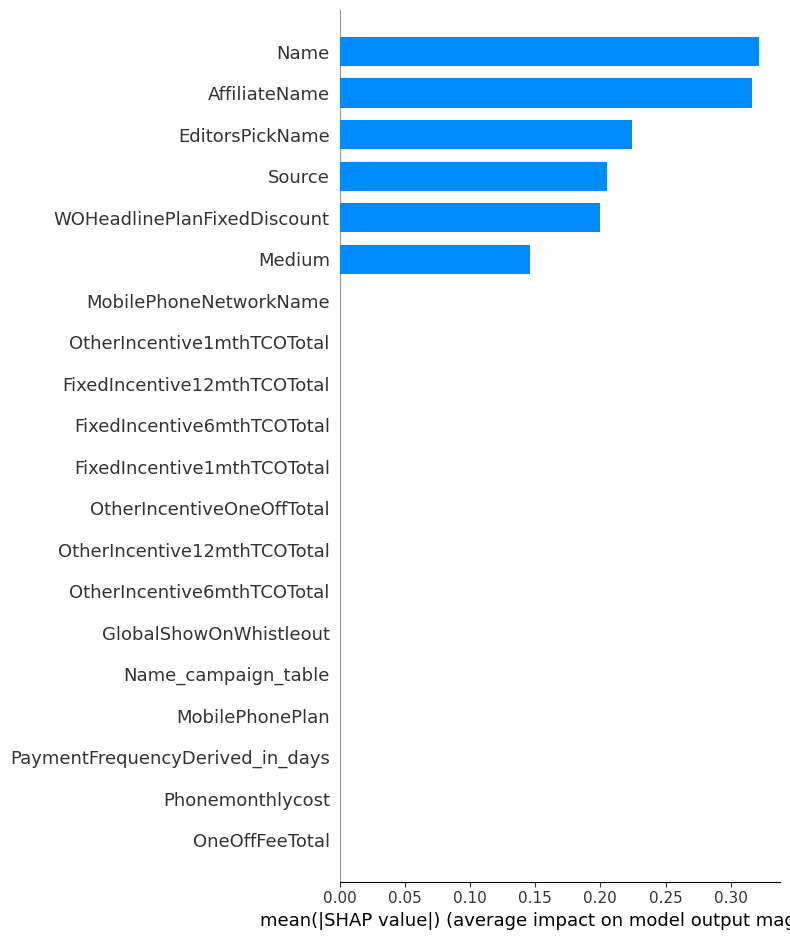

Validation Accuracy: 0.9961734693877551
Test Accuracy: 0.9961750956226094
Training Accuracy: 0.9958094196957274


In [ ]:
# Analyze which features attributed to transaction
print('df:', df.shape)
# Example usage
analyze(df, 'IsTransaction', label_encoders)

## 4 Market share for date

In [ ]:
df_mkt_share.columns

Index(['ViewedOnDate', 'IsAd', 'IsTransaction', 'AffiliateName', 'Source',
       'Medium', 'WOHeadlinePlanFixedDiscount', 'WOHeadlineExtraDataDiscount',
       'OneOffFeeTotal', 'Phonemonthlycost', 'Name',
       'PaymentFrequencyDerived_in_days', 'GlobalShowOnWhistleout',
       'EditorsPickName', 'Name_campaign_table', 'OtherIncentive1mthTCOTotal',
       'OtherIncentive6mthTCOTotal', 'OtherIncentive12mthTCOTotal',
       'OtherIncentiveOneOffTotal', 'FixedIncentive1mthTCOTotal',
       'FixedIncentive6mthTCOTotal', 'FixedIncentive12mthTCOTotal',
       'FixedIncentiveOneOffTotal', 'PercentageIncentive1mthTCOTotal',
       'PercentageIncentive6mthTCOTotal', 'PercentageIncentive12mthTCOTotal',
       'PercentageIncentiveOneOffTotal', 'PhoneIncentive1mthTCOTotal',
       'PhoneIncentive6mthTCOTotal', 'PhoneIncentive12mthTCOTotal',
       'ExtraIncentive1mthTCOTotal', 'ExtraIncentive6mthTCOTotal',
       'ExtraIncentive12mthTCOTotal', 'ExtraIncentiveOneOffTotal',
       'Name_supplier_

In [ ]:
df_mkt_share.shape

(122087, 47)

In [ ]:
df_mkt_share = df_mkt_share[df_mkt_share['Name_supplier_table'] == 'iiNet']
df_mkt_share = df_mkt_share.drop(columns=['Name_supplier_table'])
df_mkt_share.shape

(15682, 46)

In [ ]:
# Only take IsTransaction = 1
df_mkt_share = df_mkt_share[df_mkt_share['IsTransaction'] == 1]

# Calculate the total transaction count for the specific product and date
transaction_count_for_plan = df_mkt_share.groupby(['ViewedOnDate', 'Name'])['IsTransaction'].transform('sum')

# Calculate the total transaction count across the entire market for that date
total_transaction_count_across_market = df_mkt_share.groupby('ViewedOnDate')['IsTransaction'].transform('sum')

# Calculate the market share using the equation
df_mkt_share['market_share'] = transaction_count_for_plan / total_transaction_count_across_market

# If you want the market share as a percentage (multiply by 100)
df_mkt_share['market_share'] = df_mkt_share['market_share']

# Print first 5 rows
print(df_mkt_share.head(5))

      ViewedOnDate  IsAd  IsTransaction     AffiliateName   Source   Medium  \
55793   2023-01-26     0              1  WhistleOut (PPC)   google      cpc   
55794   2023-01-27     0              1        WhistleOut  unknown  unknown   
55795   2023-02-20     0              1  WhistleOut (PPC)   google      cpc   
55796   2023-01-31     0              1  WhistleOut (PPC)   google      cpc   
55798   2023-02-14     0              1        WhistleOut  unknown  unknown   

       WOHeadlinePlanFixedDiscount  WOHeadlineExtraDataDiscount  \
55793                         9.99                          0.0   
55794                         9.99                          0.0   
55795                         9.99                          0.0   
55796                         9.99                          0.0   
55798                         9.99                          0.0   

       OneOffFeeTotal  Phonemonthlycost  ... DomesticMmsRate  IncludedDataMB  \
55793             0.0               0.0  .

In [ ]:
df_mkt_share = df_mkt_share.drop('ViewedOnDate', axis=1)

df_mkt_share: (15618, 46)


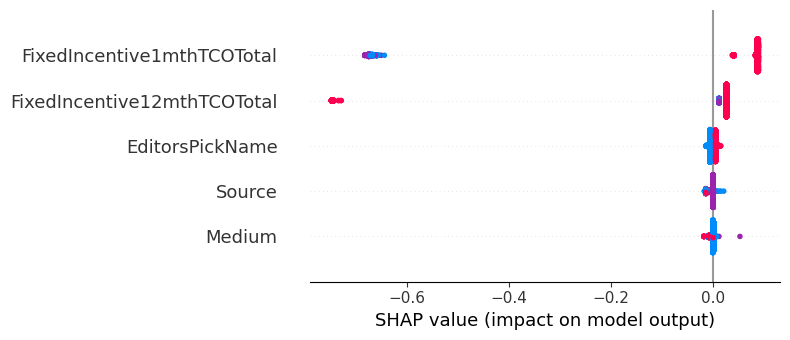

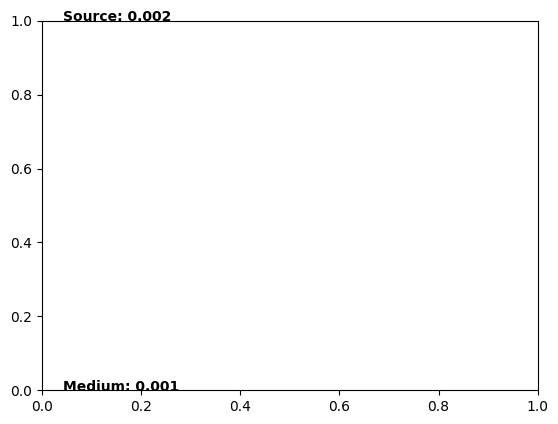

Validation MSE: 0.0027157835536333157
Test MSE: 0.0027104057814302304
Training MSE: 0.002588251955976821


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
import numpy as np

warnings.filterwarnings("ignore")

# Define the columns to be encoded
columns_to_encode = ['AffiliateName', 'Source', 'Medium', 'Name', 'Name_campaign_table', 'MobilePlanTypeName', 'MobilePlanTypeNameDerived', 'MobilePhoneNetworkName']

# Initialize an empty dictionary to store the label encoders
label_encoders = {}

# Apply label encoding to each column
for column in columns_to_encode:
    le = LabelEncoder()
    df_mkt_share[column] = le.fit_transform(df_mkt_share[column])
    label_encoders[column] = le

def analyze(df, y_column):
    # Separate the target variable from the features
    X = df.drop(y_column, axis=1)
    y = df[y_column]

    # Split the data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Initialize and fit a Decision Tree model for regression
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)

    # Create a SHAP explainer for the model
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values for the validation data
    shap_values = explainer.shap_values(X_valid)

    # Calculate feature importances from SHAP values
    feature_importances = np.abs(shap_values).mean(axis=0)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importances)

    # Get the top 5 feature names
    top_feature_names = X_valid.columns[sorted_idx][-5:]

    # Get the corresponding feature importance values
    top_feature_importance = feature_importances[sorted_idx][-5:]

    # Plot the SHAP summary plot for the top 5 features
    shap.summary_plot(shap_values, X_valid, feature_names=X_valid.columns, plot_type="dot", max_display=5, color_bar=False)

    # Add annotations for feature names and values
    for i, name in enumerate(top_feature_names):
        plt.annotate(f"{name}: {top_feature_importance[i]:.3f}", (0, i), xytext=(15, 0), textcoords='offset points', fontsize=10, color='black', weight='bold')

    plt.show()

    # Predict on the validation set
    y_valid_pred = model.predict(X_valid)

    # Calculate mean squared error (MSE) for validation set
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    print('Validation MSE:', valid_mse)

    # Predict on the test set
    y_test_pred = model.predict(X_test)

    # Calculate mean squared error (MSE) for the test set
    test_mse = mean_squared_error(y_test, y_test_pred)
    print('Test MSE:', test_mse)

    # Predict on the training set
    y_train_pred = model.predict(X_train)

    # Calculate mean squared error (MSE) for the training set
    train_mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', train_mse)


# Analyze using 'market_share' as the target variable
print('df_mkt_share:', df_mkt_share.shape)
analyze(df_mkt_share, 'market_share')